In [3]:
#| echo: false
#| eval: falseq
# %load_ext autoreload 
# %autoreload 2

---
title: "Language Modelling with RNNS"
author: Deepam Minda
date: "July 20, 2024"
categories: [rnns, nlp, seq-to-seq, langauge-modelling]
format:
  html:
    toc: true
    toc-depth: 3
    html-math-method: katex
    code-fold: true
    code-summary: "show code"
    highlight-style: github
execute:
  warning: false

---

# Introduction

The only reason you would be hearing RNNs right now is probably when [xLSTMs](https://arxiv.org/pdf/2405.04517) were released in May, 2024. Apart from this they have pretty much taken a back seat to watch transformers revolutionalize NLP and the entire field of AI in general. 

But one would do well to remember how we got here, and RNNs played a massive role in bringing us here. So in this blog post I'm going to build a small RNN model and we'll try to train it to generate text.

# Import data and process it

In [4]:
#| code-fold: false
import torch
import torch.nn as nn
import random
import numpy as np 

Let us load a text dataset. I downloaded a few mystery books and concatenated their raw text to make the dataset. Follow [this](https://github.com/mindadeepam/mindadeepam.github.io/blob/posts/posts/rnns/corpus.txt) link to get the text file. 


In [77]:
#| code-fold: false
dataset_path = "./corpus.txt"

with open(dataset_path, 'r') as f:
    data = f.read()

Lets have a look at some of the text we have.

In [78]:
print(f"Sample data chunk:\n'{data[1000:1500]}'")

Sample data chunk:
'rld has seen, but as a lover he would have placed himself in a
false position. He never spoke of the softer passions, save with a gibe
and a sneer. They were admirable things for the observer—excellent for
drawing the veil from men’s motives and actions. But for the trained
reasoner to admit such intrusions into his own delicate and finely
adjusted temperament was to introduce a distracting factor which might
throw a doubt upon all his mental results. Grit in a sensitive
instrument, or a crack i'


Lets split the data into train and test (80-20)

In [79]:
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

print(f"train_size: {len(train_data)}, test_size: {len(test_data)}  (in number of tokens)")

train_size: 2449724, test_size: 612431  (in number of tokens)


Now let us encode the text to numerical data that our model can understand. Encoding the data generally means tokenization and then encoding. To keep it super simple, we'll just use individual characters as tokens.

Nowadays however, subword [tokenization algorithms]((https://huggingface.co/docs/transformers/main/en/tokenizer_summary)) like Byte-Pair Encoding are the norm. But let us not get caught up in those for now.

In [80]:
#| code-fold: false
# Define the vocabulary and special tokens
vocab = list(set(train_data+"12345678910qwertyuioplkjhgfdsamnbvcxz~!@#$%^&*()_+`-=[];'./,{}\":?><\|"))
PAD_TOKEN = '<pad>'
special_tokens = [PAD_TOKEN]
MAX_SEQ_LEN = 32

vocab = [*special_tokens, *vocab]

# Create mappings for encoding and decoding
decode_mapping = dict(enumerate(vocab))
encode_mapping = {v:k for k,v in decode_mapping.items()}

# Define encoding and decoding functions
encode = lambda text: [encode_mapping[char] for char in text]
decode = lambda text: [decode_mapping[char] for char in text]

Now we can do a simple sanity check by encoding a text and decoding it. we should get the original string back.

In [81]:
text = "hey there"
encoded_text = encode(text)

print(f"original text: {text}")
print(f"tokenized text: {list(text)}")
print(f'encoded text: {encoded_text}')
print(f"decoded back:{decode(encoded_text)}")

original text: hey there
tokenized text: ['h', 'e', 'y', ' ', 't', 'h', 'e', 'r', 'e']
encoded text: [74, 66, 31, 53, 104, 74, 66, 24, 66]
decoded back:['h', 'e', 'y', ' ', 't', 'h', 'e', 'r', 'e']


Now we need functions that will do this for batches of texts rather than single text. 
When dealing with batches, there are a few extra considerations: 
- You would typically want your batches to contain texts which are of same length, so that matrix/tensor operations can be performed. Hence we need to truncate longer sentences and pad shorter sentences to a fixed length.


In [82]:
#| echo: false
#| code-fold: false

def tokenize_arr(texts, max_seq_len=256):
    """
    Tokenizes a list of texts and returns the tokenized array.

    Args:
        texts (list): A list of texts to be tokenized.
        max_seq_len (int, optional): The maximum sequence length. Defaults to 256.

    Returns:
        numpy.ndarray: The tokenized array.

    """
    # texts = pad_texts(texts, max_seq_len=MAX_SEQ_LEN)
    texts = np.array(texts).reshape(-1,1)

    texts = [list(doc) for text in texts for doc in text]
    for i, text in enumerate(texts):
        if len(text)>max_seq_len:
            texts[i] = text[:max_seq_len]
        elif len(text)<max_seq_len:
            num_pad_tokens = max_seq_len-len(text)
            texts[i] = [*([PAD_TOKEN]*num_pad_tokens) + text]
    
    return np.array(texts)

def encode_arr(texts, encode_mapping=encode_mapping, max_seq_len=MAX_SEQ_LEN):
    """
    Encodes an array of texts using a given encoding mapping.

    Args:
        texts (numpy.ndarray): The array of texts to be encoded.
        encode_mapping (dict): A dictionary mapping characters to their corresponding encodings.
        max_seq_len (int): The maximum sequence length.

    Returns:
        numpy.ndarray: The encoded texts.

    """
    texts = tokenize_arr(texts, max_seq_len)
    # print(texts)
    texts = np.apply_along_axis(lambda text: [encode_mapping.get(x) for x in text], arr=texts, axis=1)
    return texts.squeeze()

def decode_arr(texts):
    """
    Decodes a list of encoded texts using a decoding mapping.
    
    Parameters:
    texts (numpy.ndarray): A numpy array of encoded texts.
    
    Returns:
    list: A list of decoded texts.
    """
    decoded_texts = np.apply_along_axis(lambda text: ([decode_mapping[x] for x in text]), arr=texts, axis=1)
    decoded_texts = decoded_texts.tolist()
    decoded_texts = ["".join(text) for text in decoded_texts]
    return decoded_texts


texts = [['hey there', "talk much", "kendirck is cool af"]]
encoded_texts = encode_arr(texts)
decoded_texts = decode_arr(encoded_texts)


For simplicity let us also define a function that will fetch us a random batch of data from our training set.

In [83]:
#| code-fold: false

def get_data(data, batch_size=16, seq_len=256):
    """
    Retrieves input and target data for training a recurrent neural network (RNN).

    Args:
        data (list): The input data.
        batch_size (int, optional): The number of sequences in each batch. Defaults to 16.
        seq_len (int, optional): The length of each sequence. Defaults to 256.

    Returns:
        tuple: A tuple containing the input and target data tensors.
            - inputs (torch.Tensor): The input data tensor.
            - targets (torch.Tensor): The target data tensor.
    """
    buffer = 1000
    l = len(data)
    start = np.random.randint(0, l - buffer, size=batch_size)
    end = start + seq_len
    texts = [data[s:e] for s, e in zip(start, end)]
    
    encoded_texts = encode_arr(texts, max_seq_len=seq_len + 1)
    targets = encoded_texts[:, 1:]
    inputs = encoded_texts[:, :-1]
    
    targets = torch.tensor(targets, dtype=torch.long)
    inputs = torch.tensor(inputs, dtype=torch.long)
    
    return inputs, targets



In [84]:
x, y = get_data(train_data, 4, 23)
print("target is just x shifted one token to the left!")
print(f"x[0]: {x[0]},\ny[0] {y[0]}")

target is just x shifted one token to the left!
x[0]: tensor([  0,  53, 104,  74,  48,  26,  45,  74, 104,  53,  17,  66,  24,  74,
         47,  17,  80,  94,  53,  53,  53,  53,  53]),
y[0] tensor([ 53, 104,  74,  48,  26,  45,  74, 104,  53,  17,  66,  24,  74,  47,
         17,  80,  94,  53,  53,  53,  53,  53,  53])


# RNNS

Now before modelling, let us look at a RNN layer and understand its input and outputs. Each RNN layer has the following basic archtecture: 

![unrolled RNN](rnn_unrolled.png){#fig-unrolled-rnn height=70%, width=70%}


## Understanding RNNs

RNNs have 2 matrices, one ($W_{xh}$) that maps input tokens to hidden_vector size and another ($W_{hh}$) that maps from hidden_vector to hidden_vector. You'll see how these are used in a minute. 

Let us first look at input-output shapes for an RNN layer. We initially had a batch of text-tokens. Lets assume batch size of 4 and max_seq_len of 32. Hence the shape of input is (4,32).

Now for each token, we encode it to a number and then map it to a vector (which we generally call an embedding). Hence each token is now represented by a vector of fixed-shape, and lets call this embedding_dimension and set it to 10.

The shape of our input batch is now (batch_size, max_seq_len, emb_dim), ie (4,32,10).

Now let us peek into the matrix multiplications inside a RNN layer. 
Firstly, lets us recall that for a linear layer, this is the matrix equation: 

$z (N, n_{out}) = \sigma(x (N, n_{in}) * W_x^T (n_{in}, n_{out}) + b (N))$

where , 

- input-features = $n_{in}$
- output-features = $n_{out}$
- batch-size = $N$

In a linear layer, each token/feature is attended to by a different weight in the weight matrix and no information is shared among the sequence tokens. But when processing "sequences" we obviously want the model to remember stuff from previous tokens for the current token, right?

Hence RNNs maintain a hidden_vector for each token, that takes as input the current token and the hidden_vector from the previous token's output.

So for the $t$'th token, 

$h_t (N, h)= x_t (N, n_{in}) * W_{xh}^T (n_{in}, h) + h_{t-1} (N, h) * W_{hh}^T (h, h) + biases$

where 

- input-features = $n_{in}$
- hidden-size = $h$
- batch-size = $N$
- sequence-length = $s$

As you'll notice since each token depends on previous tokens output, we cannot process this parallelly and have to iteratively calculate the output for each token. Also note we generally refer to the different tokens in a sequence as different timesteps, ie token at timestep t is $x_t$.


Hence for a complete batch, inputs are:

- $X$ of shape $(N, s, n_{in})$
- $h_0$ of shape $(N, h)$ (this is optional, if not given most libraries will initiate a $h_0$ of all zeros or random numbers)

And outputs are:

- hidden states of all timesteps, ie $H$ of shape $(N, s, h)$
- last_hidden_state ie $h_n$ of shape $(N, h)$


Note: sometimes you will see outputs of rnn fed into a linear layer like so,
```python
outputs, h_n = self.rnn(x)
y = self.fc(outputs[:,-1,:])
```

Here `h_n` and `outputs[:,-1,:]` are the same thing. They both represent the last hidden state for the entire batch. (to make shapes equal use `h_n.squeeze()`)

Lets verify the above by passing inputs to an rnn layer.

In [85]:
emb_dim = 50
hidden_size = 100
batch_size = 4
max_seq_len = 256

print(f"batch_size: {batch_size}, hidden_size: {hidden_size}, max_seq_len: {max_seq_len}, emb_dim: {emb_dim}")
X,y = get_data(train_data, seq_len=max_seq_len, batch_size=batch_size)
print(f"shape of initial input -> {X.shape}")

emb_layer = nn.Embedding(num_embeddings=len(vocab), embedding_dim=emb_dim)
rnn_layer = nn.RNN(input_size=emb_dim, hidden_size=hidden_size, batch_first=True, bidirectional=False, num_layers=1)

X = emb_layer(X)
print(f"post embedding; shape of input to RNN layer -> {X.shape}")
h_0 = torch.randn(1, batch_size, hidden_size)
outputs = rnn_layer(X, h_0)

print(f"RNN output shapes -> {outputs[0].shape}, {[outputs[1][i].shape for i in range(len(outputs[1]))]}")

batch_size: 4, hidden_size: 100, max_seq_len: 256, emb_dim: 50
shape of initial input -> torch.Size([4, 256])
post embedding; shape of input to RNN layer -> torch.Size([4, 256, 50])
RNN output shapes -> torch.Size([4, 256, 100]), [torch.Size([4, 100])]


# Language Modelling 

Now let us build a model and train it. For starters we'll just use a [torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) layer to build the model and train it. Once we get the entire training and testing pipeline complete, we can come back and build the model from scratch. 
    
### How exactly can we generate text though?

We know we can get hidden states of the entire sequence as outputs from a rnn layer, but each hidden state $h_t$ has ponly seen information till timestep $t$. 
What we can do is this: 

- only use the last hidden state and feed it to a linear layer with output shape equal to size of vocabulary. 
- if softmax is applied on top of the linear layer's output, it turns raw logits into the probabilities for different tokens in our vocab. This can be done outside the forward function too.

Now each input sequence gives us one output token ie $y_{t+1}$. then we can take the sequence from $1$ to $t+1$ and generate token $y_{t+2}$. 

### During Training

To maximize training we can use all hidden state outputs instead of the last one. Because why wouldnt we want the model to learn from all its outputs!

- output of rnn layer of shape $(N, s, h)$ is fed into a linear layer of shape $(h, vocab\_size)$ to get $(N,s,vocab\_size)$ outputs. then we can pass them via softmax and apply cross-entropy loss on all of them and backpropagate through the model.
- since at token level we now have $N*s$ tokens on which we will calculate loss, its simpler to flatten the targets and generated logits before passing to cross-entropy loss.

Note: Had it been a classification task, we could just pass last hidden_state, $h_n$ to a linear layer with output size equal to number of classes.

## The model

In [94]:
#| code-fold: false
class Rnn_model(nn.Module):

    def __init__(self, embedding_size, max_seq_len, hidden_size, num_layers=1, vocab_size=None):
        """
        Initializes the Rnn_model class.

        Args:
            embedding_size (int): The size of the embedding dimension.
            max_seq_len (int): The maximum sequence length.
            hidden_size (int): The size of the hidden state dimension.
            num_layers (int, optional): The number of recurrent layers. Defaults to 1.
            vocab_size (int, optional): The size of the vocabulary. Defaults to None.

        """
        super(Rnn_model, self).__init__()

        self.max_seq_len = max_seq_len
        self.vocab_size = len(vocab) if vocab_size is None else vocab_size
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, embedding_dim=embedding_size)
        self.rnn = nn.RNN(input_size=embedding_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layers)
        self.fc = nn.Linear(hidden_size, len(vocab))
        self.softmax = nn.Softmax(dim=-1)
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore pad token

    def forward(self, x, targets=None):
        """ 
        a forward pas thorugh the model.
        x: input torch tensor (B,T,S)
        targets: input targets (B,T,S)

        Returns
        (model output logits, loss)
        """
        x = x[:, -self.max_seq_len:]
        x = self.embedding(x)
        H, h_n = self.rnn(x)

        # y = self.fc(H[:,-1,:])
        y = self.fc(H)
        
        if targets is not None:
            B, T, V = y.shape
            loss = self.criterion(y.view(B*T, V), targets.view(-1))
        else: loss=None
        
        return y, loss
    
    
    @torch.no_grad
    def generate(self, input_text, max_len=32):
        """ 
        input_text: a string or list of strings to generate text using the model.
        max_len: model will generate maximum of max_len tokens.
        """
        encoded_tokens = torch.tensor(encode_arr([input_text], max_seq_len=32))
        if encoded_tokens.ndim == 1:
            encoded_tokens = encoded_tokens.unsqueeze(0)

        for i in range(max_len):
            outputs, _ = self(encoded_tokens[:, -self.max_seq_len:])

            # last output token
            outputs = outputs[:, -1, :]

            # get pribabilities from logits
            next_token_probs = nn.functional.softmax(outputs, dim=-1)

            # sample indices from it using a multinomial distribution
            next_tokens = torch.multinomial(next_token_probs, 1)

            # concat prediction to original text
            encoded_tokens = torch.concat((encoded_tokens, next_tokens), axis=1)

        decoded_texts = decode_arr(encoded_tokens)
        if len(decoded_texts)==1:
            return decoded_texts[0] #.replace("<pad>", "") 
        else: 
            # return [text.replace("<pad>", "") for text in decoded_texts]
            return decoded_texts

In [95]:
# model = Rnn_model(embedding_size=10, max_seq_len=32, hidden_size=20, num_layers=1)
# x, y = get_data(train_data, 4, 32)
# y_hat, loss = model(x)
# x.shape, y.shape

# print(y.shape, y_hat.shape)
# # y = y.view(-1)
# B, T, V = y_hat.shape
# y_hat.view(B*T, V)

# loss = nn.CrossEntropyLoss(ignore_index=0)
# loss(y_hat.view(B*T, V), y.view(-1))
# # loss(y_hat, y)
# # y.shape, y_hat.shape


# input_text = ["whats up my G GGGGG", "hey there"]
# max_seq_len=32
# encoded_tokens = torch.tensor(encode_arr([input_text], max_seq_len=max_seq_len))
# print(encoded_tokens)
# if encoded_tokens.ndim == 1:
#     encoded_tokens = encoded_tokens.unsqueeze(0)

# for i in range(4):
#     print(encoded_tokens.shape, encoded_tokens[:, -max_seq_len:].shape)
#     outputs = model(encoded_tokens[:, -max_seq_len:])
#     # last output token
#     next_token_probs = outputs[:, -1, :]
#     # print(next_token_probs)
#     # sample indices from it using a multinomial distribution
#     next_tokens = torch.multinomial(next_token_probs, 1)
#     # print(next_tokens)
#     encoded_tokens = torch.concat((encoded_tokens, next_tokens), axis=1)

# print(encoded_tokens)


## Training loop

In [96]:
#| code-fold: false

NUM_STEPS = 1000
MAX_SEQ_LEN = 64
BATCH_SIZE = 32
EMBEDDING_SIZE = 20
HIDDEN_SIZE = 50
NUM_LAYERS = 2
LR = 0.001 
log_every = 50

model = Rnn_model(embedding_size=EMBEDDING_SIZE, max_seq_len=MAX_SEQ_LEN, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
losses = []
for i in range(NUM_STEPS):
    optimizer.zero_grad()
    x, y = get_data(train_data, BATCH_SIZE, MAX_SEQ_LEN)
    outputs, loss = model(x, y)
    loss.backward()
    optimizer.step()
    if i%log_every==0:
        losses.append(loss)

losses = [loss.detach().numpy().item() for loss in losses] 
print(losses[::3])

[4.754984378814697, 2.9505343437194824, 2.4850621223449707, 2.314824104309082, 2.132694721221924, 2.0362727642059326, 2.0536997318267822]


Text(0, 0.5, 'Loss')

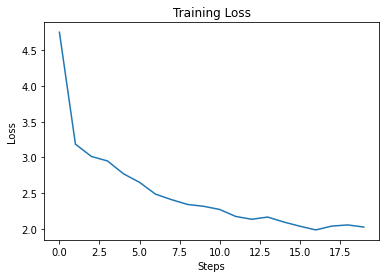

In [97]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")

- sqitching from SGD to adam instantly gives boost (2.8 vs under 2)
- tripling the data gave no gains on 50k basic rnn model!

Lets look at some outputs from the model.

In [99]:
#|code-fold: false
for line in model.generate(["hey there handsome what", "I recall "]):
    print(line.replace("<pad>", ""))

hey there handsome what you reoth the that the beive do
I recall the sroad tood oulf the inlow hi


In [93]:
# calculate size of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"paramter count of the model: {count_parameters(model)}")

paramter count of the model: 43320


The results dont make much sense, but the model is learning to generate text. By scaling the model and training for longer, we can get better results.

Thank you for reading this and I hope you found it useful. The next time I update this blog post, I'll be adding the following:

- Evaluation on test set (metrics like perplexity).
- Implementing RNN, LSTM and GRU from scratch.

Byee :)

# References

1. [OG blog by Karpathy](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)
2. [RNN torch documentation](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN)